<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/gimseng/99-ML-Learning-Projects/blob/master/001/solution/titanic_tf_nn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Data Processing
First we can import the relevant libraries.

In [1]:
import numpy as np
import pandas as pd

Next we can download the data from github using pandas.

In [2]:
project_url = 'https://raw.githubusercontent.com/gimseng/99-ML-Learning-Projects/'
data_path = 'master/001/data/'
train=pd.read_csv(project_url+data_path+'train.csv')
test=pd.read_csv(project_url+data_path+'test.csv')

Since the datasets contain a lot of data that isn't really necessary we can remove those columns from both the train and testing datasets.

In [3]:
del train['PassengerId']
del train['Ticket']
del train['Fare']
del train['Cabin']
del train['Name']

In [4]:
del test['Ticket']
del test['Fare']
del test['Cabin']
del test['Name']

Since we want all fields to be numerical to feed into the nn we can substitute 'male' and 'female' for 0 and 1 in the 'Sex' column respectively.

In [5]:
def getNum(str):
    if str=='male':
        return 0
    if str=='female':
        return 1
train["Sex"]=train["Sex"].apply(getNum)

test["Sex"]=test["Sex"].apply(getNum)

We can now do the same with the 'Embarked' column.

In [6]:
def getEmbarked(str):
    if str == 'S':
        return 0
    elif str == 'C':
        return 1
    elif str == 'Q':
        return 2
    
train["Embarked"] = train["Embarked"].apply(getEmbarked)

test["Embarked"] = test["Embarked"].apply(getEmbarked)

In [7]:
train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Embarked
0,0,3,0,22.0,1,0,0.0
1,1,1,1,38.0,1,0,1.0
2,1,3,1,26.0,0,0,0.0
3,1,1,1,35.0,1,0,0.0
4,0,3,0,35.0,0,0,0.0


In [8]:
test.head()

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Embarked
0,892,3,0,34.5,0,0,2
1,893,3,1,47.0,1,0,0
2,894,2,0,62.0,0,0,2
3,895,3,0,27.0,0,0,0
4,896,3,1,22.0,1,1,0


# Neural Network (Pytortch)

First we can import pytorch.

In [9]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

Now we can define our hyperparameters

In [10]:
BATCH_SIZE = 10
LR = 1e-4
LR_DECAY = 1e-6
VALIDATION_SPLIT = 0.2
EPOCHS = 800

Then we need to convert the pandas dataframes to lists of pytorch tensors to be passed through our network

In [11]:
X = []
y = []

for cbatch in range(len(train.values)//BATCH_SIZE):
    batch_X = []
    batch_y = []
    for value in train.values[(cbatch*BATCH_SIZE):((cbatch*BATCH_SIZE)+BATCH_SIZE)]:
        if np.isnan(value[3]):
            value[3] = float(30)
            
        if np.isnan(value[6]):
            value[6] = 0
        
        value[3] = round(value[3]/100, 6)
            
        batch_X.append(value[1::])
        batch_y.append(int(value[0]))
        
    X.append(torch.Tensor(batch_X))
    y.append(torch.Tensor(batch_y))

Now we split the dataset up into training and validation data using our VALIDATION_SPLIT hyperparameter

In [12]:
X_train = X[0:int(len(X)*(1-VALIDATION_SPLIT))]
y_train = y[0:int(len(X)*(1-VALIDATION_SPLIT))]

In [13]:
X_val = X[int(len(X)*(1-VALIDATION_SPLIT))::]
y_val = y[int(len(X)*(1-VALIDATION_SPLIT))::]

In [14]:
print(len(X_val))
print(len(X_train))
print(len(y_val))
print(len(y_train))

18
71
18
71


Next we define the nn model

In [15]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(6, 8)
        self.fc2 = nn.Linear(8, 6)
        self.fc3 = nn.Linear(6, 4)

        self.fc4 = nn.Linear(4, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
         
        return F.log_softmax(x, dim=1)

then initialize both the model and the optimizer with the learning rate hyperparameters

In [16]:
net = Net()

optimizer = optim.Adam(net.parameters(), lr=LR, eps=LR_DECAY)

Now we can train the network. I am logging the in-sample loss, validation loss and validation accuracy and storing them in a list after each epoch.

In [17]:
epoch_loss = []
epoch_VAL_loss = []
epoch_VAL_acc = []

for epoch in range(EPOCHS):
    for batch in range(len(X_train)):
        curr_X = X_train[batch]
        curr_y = y_train[batch]
        
        net.zero_grad()
        output = net(curr_X.view(-1, 6))
        loss = F.nll_loss(output, curr_y.long())
        
        loss.backward()
        optimizer.step()
        
    # Validation
    total = 0
    correct = 0
    
    with torch.no_grad():
        for batch in range(len(X_val)):
            curr_X = X_val[batch]
            curr_y = y_val[batch]
            
            output = net(curr_X.view(-1, 6))
            VAL_loss = F.nll_loss(output, curr_y.long())
            
            for idx, i in enumerate(output):
                if torch.argmax(i) == curr_y[idx]:
                    correct += 1
                total += 1
    
    epoch_loss.append(round(float(loss), 5))
    epoch_VAL_loss.append(round(float(VAL_loss), 5))
    epoch_VAL_acc.append(round(correct/total, 5))
    
    print(f"Epoch: {epoch}/{EPOCHS} Loss: {round(float(loss), 3)}, val_loss: {round(float(VAL_loss), 3)}, val_acc: {round(correct/total, 3)}")

Epoch: 0/800 Loss: 0.748, val_loss: 0.627, val_acc: 0.639
Epoch: 1/800 Loss: 0.748, val_loss: 0.627, val_acc: 0.639
Epoch: 2/800 Loss: 0.747, val_loss: 0.627, val_acc: 0.639
Epoch: 3/800 Loss: 0.747, val_loss: 0.626, val_acc: 0.639
Epoch: 4/800 Loss: 0.746, val_loss: 0.626, val_acc: 0.639
Epoch: 5/800 Loss: 0.746, val_loss: 0.625, val_acc: 0.639
Epoch: 6/800 Loss: 0.745, val_loss: 0.625, val_acc: 0.639
Epoch: 7/800 Loss: 0.744, val_loss: 0.625, val_acc: 0.639
Epoch: 8/800 Loss: 0.744, val_loss: 0.624, val_acc: 0.639
Epoch: 9/800 Loss: 0.743, val_loss: 0.624, val_acc: 0.639
Epoch: 10/800 Loss: 0.742, val_loss: 0.623, val_acc: 0.639
Epoch: 11/800 Loss: 0.74, val_loss: 0.623, val_acc: 0.639
Epoch: 12/800 Loss: 0.739, val_loss: 0.622, val_acc: 0.639
Epoch: 13/800 Loss: 0.737, val_loss: 0.621, val_acc: 0.639
Epoch: 14/800 Loss: 0.735, val_loss: 0.62, val_acc: 0.639
Epoch: 15/800 Loss: 0.732, val_loss: 0.619, val_acc: 0.639
Epoch: 16/800 Loss: 0.73, val_loss: 0.618, val_acc: 0.639
Epoch: 17/

Epoch: 140/800 Loss: 0.625, val_loss: 0.405, val_acc: 0.833
Epoch: 141/800 Loss: 0.625, val_loss: 0.405, val_acc: 0.833
Epoch: 142/800 Loss: 0.625, val_loss: 0.404, val_acc: 0.833
Epoch: 143/800 Loss: 0.625, val_loss: 0.403, val_acc: 0.833
Epoch: 144/800 Loss: 0.624, val_loss: 0.402, val_acc: 0.833
Epoch: 145/800 Loss: 0.624, val_loss: 0.402, val_acc: 0.833
Epoch: 146/800 Loss: 0.624, val_loss: 0.401, val_acc: 0.833
Epoch: 147/800 Loss: 0.624, val_loss: 0.401, val_acc: 0.833
Epoch: 148/800 Loss: 0.624, val_loss: 0.4, val_acc: 0.833
Epoch: 149/800 Loss: 0.623, val_loss: 0.4, val_acc: 0.833
Epoch: 150/800 Loss: 0.623, val_loss: 0.399, val_acc: 0.833
Epoch: 151/800 Loss: 0.623, val_loss: 0.398, val_acc: 0.833
Epoch: 152/800 Loss: 0.623, val_loss: 0.398, val_acc: 0.833
Epoch: 153/800 Loss: 0.623, val_loss: 0.397, val_acc: 0.833
Epoch: 154/800 Loss: 0.623, val_loss: 0.397, val_acc: 0.833
Epoch: 155/800 Loss: 0.622, val_loss: 0.396, val_acc: 0.833
Epoch: 156/800 Loss: 0.622, val_loss: 0.396,

Epoch: 280/800 Loss: 0.598, val_loss: 0.352, val_acc: 0.839
Epoch: 281/800 Loss: 0.598, val_loss: 0.352, val_acc: 0.839
Epoch: 282/800 Loss: 0.598, val_loss: 0.351, val_acc: 0.839
Epoch: 283/800 Loss: 0.598, val_loss: 0.351, val_acc: 0.839
Epoch: 284/800 Loss: 0.597, val_loss: 0.351, val_acc: 0.839
Epoch: 285/800 Loss: 0.597, val_loss: 0.351, val_acc: 0.839
Epoch: 286/800 Loss: 0.597, val_loss: 0.35, val_acc: 0.839
Epoch: 287/800 Loss: 0.597, val_loss: 0.35, val_acc: 0.839
Epoch: 288/800 Loss: 0.597, val_loss: 0.35, val_acc: 0.839
Epoch: 289/800 Loss: 0.597, val_loss: 0.35, val_acc: 0.839
Epoch: 290/800 Loss: 0.596, val_loss: 0.349, val_acc: 0.839
Epoch: 291/800 Loss: 0.596, val_loss: 0.349, val_acc: 0.844
Epoch: 292/800 Loss: 0.596, val_loss: 0.349, val_acc: 0.844
Epoch: 293/800 Loss: 0.596, val_loss: 0.349, val_acc: 0.844
Epoch: 294/800 Loss: 0.596, val_loss: 0.349, val_acc: 0.844
Epoch: 295/800 Loss: 0.596, val_loss: 0.349, val_acc: 0.844
Epoch: 296/800 Loss: 0.595, val_loss: 0.349,

Epoch: 419/800 Loss: 0.59, val_loss: 0.332, val_acc: 0.844
Epoch: 420/800 Loss: 0.59, val_loss: 0.332, val_acc: 0.844
Epoch: 421/800 Loss: 0.59, val_loss: 0.332, val_acc: 0.844
Epoch: 422/800 Loss: 0.59, val_loss: 0.331, val_acc: 0.844
Epoch: 423/800 Loss: 0.59, val_loss: 0.331, val_acc: 0.844
Epoch: 424/800 Loss: 0.59, val_loss: 0.331, val_acc: 0.844
Epoch: 425/800 Loss: 0.59, val_loss: 0.331, val_acc: 0.844
Epoch: 426/800 Loss: 0.589, val_loss: 0.331, val_acc: 0.844
Epoch: 427/800 Loss: 0.589, val_loss: 0.331, val_acc: 0.844
Epoch: 428/800 Loss: 0.589, val_loss: 0.331, val_acc: 0.844
Epoch: 429/800 Loss: 0.589, val_loss: 0.331, val_acc: 0.844
Epoch: 430/800 Loss: 0.589, val_loss: 0.331, val_acc: 0.844
Epoch: 431/800 Loss: 0.589, val_loss: 0.331, val_acc: 0.844
Epoch: 432/800 Loss: 0.589, val_loss: 0.33, val_acc: 0.844
Epoch: 433/800 Loss: 0.589, val_loss: 0.33, val_acc: 0.844
Epoch: 434/800 Loss: 0.589, val_loss: 0.33, val_acc: 0.844
Epoch: 435/800 Loss: 0.589, val_loss: 0.33, val_ac

Epoch: 559/800 Loss: 0.587, val_loss: 0.322, val_acc: 0.844
Epoch: 560/800 Loss: 0.587, val_loss: 0.321, val_acc: 0.844
Epoch: 561/800 Loss: 0.587, val_loss: 0.321, val_acc: 0.844
Epoch: 562/800 Loss: 0.587, val_loss: 0.321, val_acc: 0.844
Epoch: 563/800 Loss: 0.587, val_loss: 0.321, val_acc: 0.844
Epoch: 564/800 Loss: 0.587, val_loss: 0.321, val_acc: 0.844
Epoch: 565/800 Loss: 0.587, val_loss: 0.321, val_acc: 0.844
Epoch: 566/800 Loss: 0.587, val_loss: 0.321, val_acc: 0.844
Epoch: 567/800 Loss: 0.587, val_loss: 0.321, val_acc: 0.844
Epoch: 568/800 Loss: 0.587, val_loss: 0.321, val_acc: 0.844
Epoch: 569/800 Loss: 0.587, val_loss: 0.322, val_acc: 0.844
Epoch: 570/800 Loss: 0.586, val_loss: 0.321, val_acc: 0.844
Epoch: 571/800 Loss: 0.586, val_loss: 0.321, val_acc: 0.844
Epoch: 572/800 Loss: 0.586, val_loss: 0.322, val_acc: 0.844
Epoch: 573/800 Loss: 0.586, val_loss: 0.321, val_acc: 0.844
Epoch: 574/800 Loss: 0.586, val_loss: 0.321, val_acc: 0.844
Epoch: 575/800 Loss: 0.586, val_loss: 0.

Epoch: 696/800 Loss: 0.585, val_loss: 0.323, val_acc: 0.839
Epoch: 697/800 Loss: 0.585, val_loss: 0.323, val_acc: 0.839
Epoch: 698/800 Loss: 0.585, val_loss: 0.323, val_acc: 0.839
Epoch: 699/800 Loss: 0.585, val_loss: 0.323, val_acc: 0.839
Epoch: 700/800 Loss: 0.585, val_loss: 0.323, val_acc: 0.839
Epoch: 701/800 Loss: 0.585, val_loss: 0.323, val_acc: 0.839
Epoch: 702/800 Loss: 0.585, val_loss: 0.323, val_acc: 0.839
Epoch: 703/800 Loss: 0.585, val_loss: 0.323, val_acc: 0.839
Epoch: 704/800 Loss: 0.585, val_loss: 0.323, val_acc: 0.839
Epoch: 705/800 Loss: 0.586, val_loss: 0.323, val_acc: 0.839
Epoch: 706/800 Loss: 0.586, val_loss: 0.323, val_acc: 0.839
Epoch: 707/800 Loss: 0.586, val_loss: 0.323, val_acc: 0.839
Epoch: 708/800 Loss: 0.586, val_loss: 0.323, val_acc: 0.839
Epoch: 709/800 Loss: 0.586, val_loss: 0.323, val_acc: 0.839
Epoch: 710/800 Loss: 0.586, val_loss: 0.323, val_acc: 0.839
Epoch: 711/800 Loss: 0.586, val_loss: 0.322, val_acc: 0.839
Epoch: 712/800 Loss: 0.586, val_loss: 0.

Now we can use matplotlib to plot the results of our model

In [18]:
import matplotlib.pyplot as plt

This is the in-sample loss

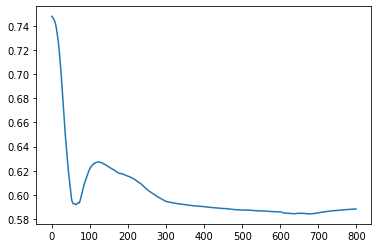

In [19]:
plt.plot(epoch_loss)
plt.show()

this is validation loss

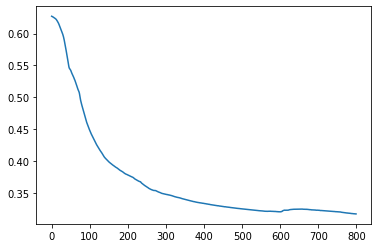

In [20]:
plt.plot(epoch_VAL_loss)
plt.show()

and this is our validation accuracy

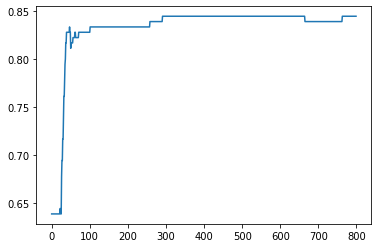

In [21]:
plt.plot(epoch_VAL_acc)
plt.show()

Since the results look good we can now run the testing dataset through the trained network

First we need to convert it to pytorch tensors

In [22]:
X_test = []
X_test_df=test.drop('PassengerId', axis=1).copy()

for value in X_test_df.values:
    if np.isnan(value[2]):
        value[2] = 30
        
    value[2] = value[2]/100
    
    X_test.append(torch.Tensor(value))

Then we can run the data through the network and store the predictions

In [23]:
predictions = []
for data in X_test:
    prediction = torch.argmax(net(data.view(-1, 6)))
    predictions.append(int(prediction))

And finally we can save the predictions to a csv file

In [24]:
output = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predictions})
output.to_csv('prediction_pt.csv', index=False)